## ML 7. Практика. Прогнозирование биологического ответа

In [1]:
#импорт библиотек
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn import linear_model
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import cross_val_score 
import hyperopt 
from hyperopt import hp, fmin, tpe, Trials 
import optuna 

%matplotlib inline
plt.style.use('seaborn')

c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Anna\AppData\Local\Temp\ipykernel_34884\957360115.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [4]:
X = data.drop('Activity', axis=1)
y = data['Activity']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Для начала обучим модели без настройки гиперпараметров:

In [6]:
# Логистическая
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
# Обучаем модель
log_reg.fit(X_train, y_train)
# Делаем предсказание
y_test_pred = log_reg.predict(X_test)
# Вычисляем значение целевой метрики
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


In [7]:
# Случайный лес
# Создаем объект класса случайный лес
ran_for = ensemble.RandomForestClassifier()
# Обучаем модель
ran_for.fit(X_train, y_train)
# Делаем предсказание
y_test_pred = ran_for.predict(X_test)
# Вычисляем значение целевой метрики
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


Значения целевой метрики на тестовой выборке для моделей логистической регрессии и случайного леса составили 0.78 и 0.8 соответсвенно.

Теперь приступим к оптимизации

## Базовые методы:

### Grid Search CV

* Логистическая регрессия

In [8]:
# Задаем сетку параметров
param_grid = {'penalty': ['l2', 'l1'] ,
              'solver': ['liblinear', 'saga'], 'C': [0.1,0.3,0.5,0.7,0.9,1]}
# Создаем объект класса 
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
# Обучаем, предсказываем и вычисляем метрику
%time grid_search.fit(X_train, y_train) 
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))


CPU times: total: 969 ms
Wall time: 13min 36s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


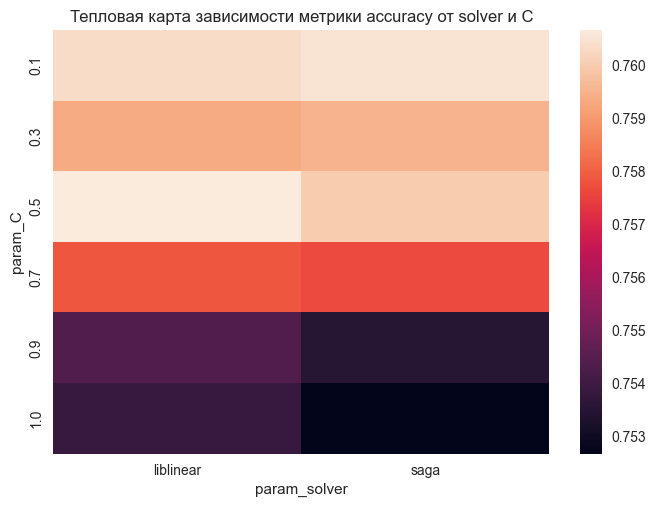

In [9]:
# Посмотрим на результаты кросс-валидации
visual = pd.pivot_table(pd.DataFrame(grid_search.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С')
sns.set(rc={'figure.figsize':(12, 8)})

* Случайный лес

In [10]:
param_grid2 = {'n_estimators': list(range(200, 500, 30)),
              'min_samples_leaf': list(range(5, 25, 5)),
              'max_depth': list(range(5, 30, 5))
              }
# Создаем объект класса 
grid_search2 = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid2, 
    cv=5, 
    n_jobs = -1
)  


In [11]:
# Обучаем, предсказываем и вычисляем метрику
%time grid_search2.fit(X_train, y_train) 
y_test_pred = grid_search2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search2.best_params_))

CPU times: total: 13 s
Wall time: 18min 56s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 380}


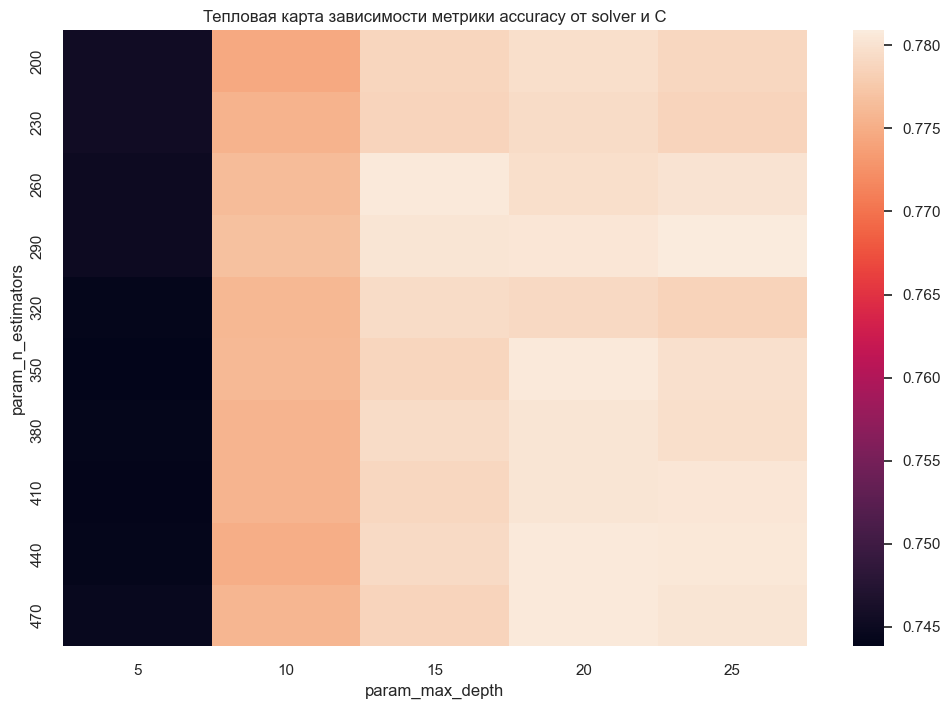

In [12]:
# Посмотрим на результаты кросс-валидации
visual = pd.pivot_table(pd.DataFrame(grid_search2.cv_results_),
                        values='mean_test_score', index='param_n_estimators',
                        columns='param_max_depth')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С')
sns.set(rc={'figure.figsize':(12, 8)})

Был произведен подбор гиперпараметров с помощью Grid Search CV. Для модели логистической регрессии метрику увеличить не удалось, затраченное время составляет примерно 15-18 минут. Для модели случайного леса так же не удалось увеличить метрику, затраченное время - примерно 18-20 минут. 

Построенные тепловые карты наглядно показывают, как меняется точность модели в зависимости от ее гиперпараметров. Это позволяет в дальнейшем уменьшить диапазон искомых параметров и сократить время оптимизации.

### Randomized Search CV

* Логистическая регрессия

In [13]:
# Задаем возможные параметры
param_distributions = {'penalty': ['l2', 'l1'] ,
              'solver': ['liblinear', 'saga'], 'C':[0.1, 0.3, 0.5, 0.7, 0.9, 1]},
# Создаем объект класса           
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
# Обучаем, предсказываем и вычисляем метрику
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 703 ms
Wall time: 8min 36s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.3}


* Случайный лес

In [14]:
# Задаем возможные параметры
param_distributions2 = {'n_estimators': list(range(200, 500, 30)),
              'min_samples_leaf': list(range(5, 25, 5)),
              'max_depth': list(range(5, 30, 5))
              },
# Создаем объект класса           
random_search2 = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions2, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
# Обучаем, предсказываем и вычисляем метрику
%time random_search2.fit(X_train, y_train) 
y_test_pred = random_search2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search2.best_params_))

CPU times: total: 7.22 s
Wall time: 1min 7s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 380, 'min_samples_leaf': 5, 'max_depth': 25}


На этом этапе был произведен подбор гиперпараметров с помощью Randomized Search CV. Для модели логистической регрессии метрику увеличить не удалось, затраченное время составляет примерно 5-7 минут. Для модели случайного леса так же не удалось увеличить метрику, затраченное время - примерно 4-5 минут.

Также стоит отметить, что Grid и Randomized выбрали довольно близкие параметры, как для первой модели, так и для второй. Следовательно, с учетом кратно меньших затрат по времени, данный метод считаю более эффективным.

## Продвинутая оптимизация

### TPE

* Логистическая регрессия

In [15]:
# зададим пространство поиска гиперпараметров
space = {'penalty': hp.choice('penalty', options=['l2', 'l1'] ),
        'solver': hp.choice('solver', options=['liblinear', 'saga']), 
        'C': hp.quniform('C', 0.1, 1, 0.2)
        }
# зафиксируем random_state
random_state = 42

In [16]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'],
              'C': params['C']
              }
  
    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=1000)

    # обучаем модель с помощью кросс-валидации
    
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [17]:
# начинаем подбор гиперпараметров
trials = Trials() 

best = fmin(hyperopt_rf, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials,
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(hyperopt.space_eval(space, best)))

100%|██████████| 20/20 [14:19<00:00, 42.97s/trial, best loss: -0.7908077686739782]
Наилучшие значения гиперпараметров {'C': 0.2, 'penalty': 'l1', 'solver': 'saga'}


In [18]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(max_iter=1000,
    random_state=random_state, 
    penalty=(hyperopt.space_eval(space, best)['penalty']),
    solver=(hyperopt.space_eval(space, best)['solver']),
    C=(best['C'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


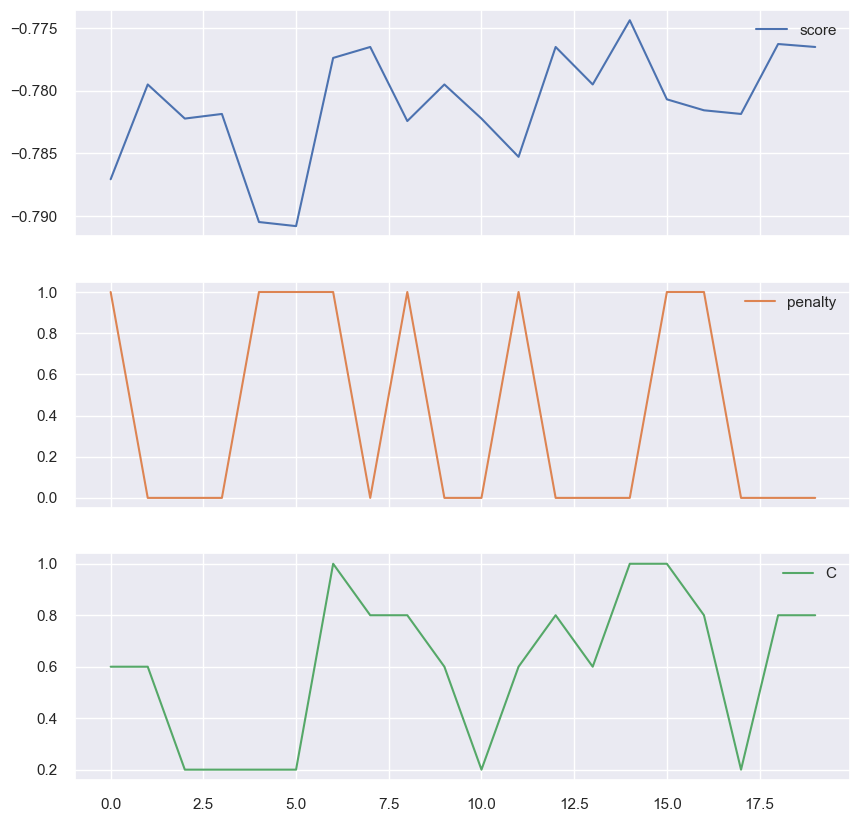

In [19]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                       x['misc']['vals']['penalty'][0],
                      x['misc']['vals']['C'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'penalty', 'C'])

tpe_results_df.plot(subplots=True,figsize=(10, 10));

* Случайный лес

In [20]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 200, 500, 30),
              'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 25, 5),
              'max_depth': hp.quniform('max_depth', 5, 30, 5)
      }
# зафиксируем random_state
random_state = 42

In [21]:
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель 
    
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [22]:
# начинаем подбор гиперпараметров
trials = Trials() 

best = fmin(hyperopt_rf, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=20, 
          trials=trials,
          rstate=np.random.default_rng(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [01:37<00:00,  4.85s/trial, best loss: -0.944647201946472]
Наилучшие значения гиперпараметров {'max_depth': 20.0, 'min_samples_leaf': 5.0, 'n_estimators': 240.0}


In [23]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


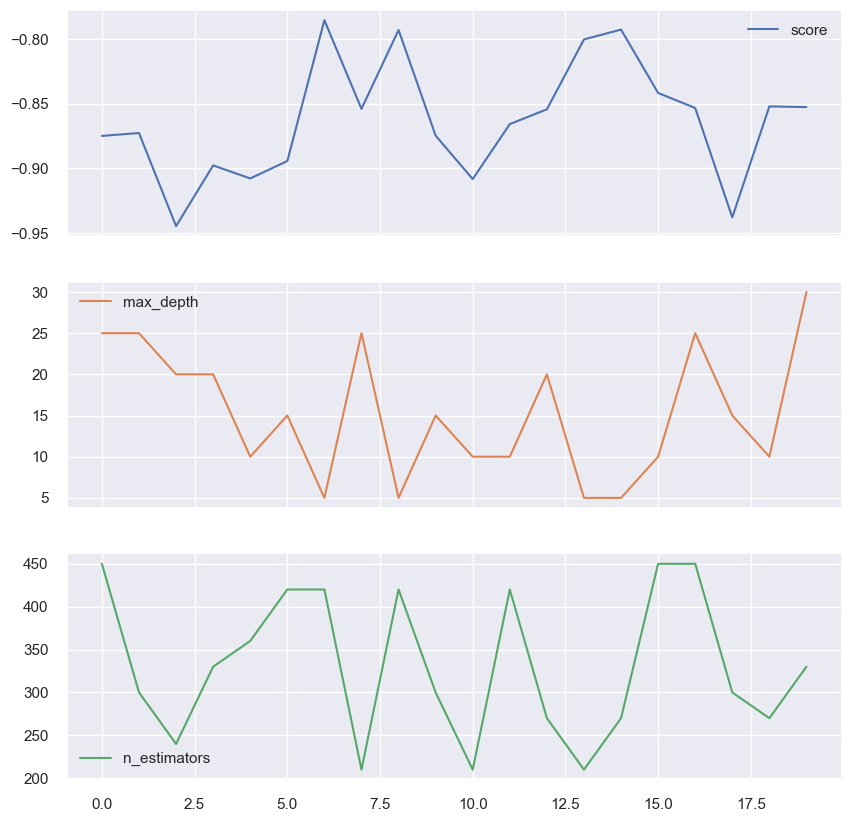

In [24]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])

tpe_results_df.plot(subplots=True,figsize=(10, 10));

Далее был произведен подбор гиперпараметров посредством TPE. Значение целевой метрики на тестовом наборе для обеих моделей увеличить не удалось. Время выполнения сократилось, особенно для модели случайного леса - примерно 1-2 минуты.  

Для наглядности изменения точности модели при различных параметрах были построены линейные графики. 

### Optuna

* Логистическая регрессия

In [25]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', 0.1, 1)

  # создаем модель
  model = linear_model.LogisticRegression(penalty = penalty, solver= solver, C=C,
                                          random_state=random_state, max_iter=1000)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [26]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-04-18 18:24:04,433] A new study created in memory with name: LogisticRegression
[I 2023-04-18 18:24:05,070] Trial 0 finished with value: 0.8664455833584563 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.20836325473585188}. Best is trial 0 with value: 0.8664455833584563.
[I 2023-04-18 18:24:05,703] Trial 1 finished with value: 0.8672299336149668 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.23377487501010927}. Best is trial 1 with value: 0.8672299336149668.
[I 2023-04-18 18:24:06,334] Trial 2 finished with value: 0.8520958083832335 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.43418187322554436}. Best is trial 1 with value: 0.8672299336149668.
[I 2023-04-18 18:24:07,214] Trial 3 finished with value: 0.8911131331513497 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.8554370877228644}. Best is trial 3 with value: 0.8911131331513497.
c:\Users\Anna\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\li

CPU times: total: 10min 37s
Wall time: 10min 39s


In [27]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'saga', 'C': 0.9844324168110886}
f1_score на обучающем наборе: 0.89


In [28]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, max_iter=1000)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


In [29]:
optuna.visualization.plot_contour(study, params=["solver", "C"],
                                  target_name="f1_score")

* Случайный лес

In [30]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 200, 500, 30)
  max_depth = trial.suggest_int('max_depth', 5, 30, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 25, 5)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [31]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-04-18 18:35:22,725] A new study created in memory with name: RandomForestClassifier
[I 2023-04-18 18:35:31,327] Trial 0 finished with value: 0.8958587088915957 and parameters: {'n_estimators': 440, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8958587088915957.
[I 2023-04-18 18:35:39,616] Trial 1 finished with value: 0.8536070027165711 and parameters: {'n_estimators': 470, 'max_depth': 15, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.8958587088915957.
[I 2023-04-18 18:35:44,942] Trial 2 finished with value: 0.8554216867469879 and parameters: {'n_estimators': 290, 'max_depth': 15, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.8958587088915957.
[I 2023-04-18 18:35:50,468] Trial 3 finished with value: 0.8525679758308157 and parameters: {'n_estimators': 380, 'max_depth': 15, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.8958587088915957.
[I 2023-04-18 18:35:53,670] Trial 4 finished with value: 0.8469387755102041 and parameters: 

CPU times: total: 1min 58s
Wall time: 1min 58s


In [32]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 320, 'max_depth': 25, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.95


In [33]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.80


In [34]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Заключительным этапом был  подбор гиперпараметров посредством Optuna. Значение целевой метрики на тестовом наборе для обеих моделей не изменились. Время выполнения так же ниже, чем у базовой оптимизации. На модели случайного леса составило 1-2 минуты, на логистической регрессии - дольше.

Визуализация помогает лучше понять, как изменение параметров влияет на значение целевой метрики моделей.

Выводы: 

В рамках данного задания удалось на практике применить знания, полученные в модуле по оптимизации  и подбору гиперпараметров модели. Были применены все вышеуказанные инструменты, в том числе с использованием кросс-валидации, проведено сравнение методов, а также выполнена визуализация полученных результатов. В целом, можно с уверенностью сказать, что продвинутые методы оптимизации работают гораздо быстрее базовых без потери эффективности.